# Evaluating trained agents

This Notebook will be used to visualize & analyze various trained agents on RiskyPath environment. Analysis will especially comprise observing the agent's behaviour in the environment it was trained for but also different versions of the environment (distributional shift analysis)

To observe deterministic agent behaviour, slipping/collision probabilities will be automatically set to zero. In this case, the agent might not be tested on the exact same environment configuration it was trained on. However, other environmental factors will behave as per the training environment's configuration. This is not the case if the model is explicitly tested on custom environments, which is obvious in the corresponding cells.

The next cell defines the folder location prefix for saved models. Set this to the location in which you have downloaded the trained models.
**Warning**: The folder structure of the saved models (inside `saved_models/…`) must not be changed and stay in the format defined by `experiment_config.py`. This is necessary as code in this notebook uses the path's information to infer environment configuration, model specifics etc.

Some cells are saved as raw format. They contain code which mostly renders agent behaviour in a specific environmental setting. This is especially useful for making videos and watching agent interaction, but otherwise not needed. 

In Jupyter, one can change raw or markdown cells to code cells by entering the command mode in the cell by pressing `esc` and then `y`. To return to raw format, use `esc` and `r`.

In [1]:
# NOTE Save the prefix for the models folder here for compatibility across different systems
model_path_prefix = "/Users/tilioschulze/Library/CloudStorage/OneDrive-Personal/Studium/Bachelorarbeit/experiment_models/saved_models/"

In [2]:
import json
import time

import gym
import gym_minigrid
from gym_minigrid.minigrid import Goal, Floor, Lava, Wall, SpikyTile
from gym_minigrid.envs import RiskyPathEnv
from gym_minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper, TensorObsWrapper
from special_wrappers import RandomizeGoalWrapper

from experiment_config import GridworldExperiment
import torch as th
import stable_baselines3
from stable_baselines3.dqn import DQN
from stable_baselines3.a2c import A2C
from stable_baselines3.common.utils import obs_as_tensor
import solver
from solver import RiskyPathSolver


import numpy as np

## Utilities

Definition of functions to use for quick analysis

In [3]:
sinfo = "\33[32mINFO:\33[0m"

def model_env_from_path(agent_path: str, no_slip: bool = True, no_rebound: bool = True):
    """Extract model, environment, observation type and tile render size from information in the model's save-path.
    In order to allow deterministic analysis of agent-environment interaction, slipping and wall rebound are turned off per default.
    """    
    # Extract model from path (a2c or dqn?)
    if "/dqn/" in agent_path:
        model_class = DQN
    elif "/a2c/" in agent_path:
        model_class = A2C

    model = model_class.load(agent_path)

    # Create environment given information in function input
    path_keys = agent_path.split("saved_models/")[1].split("/")
    env_name = path_keys[0]
    observation_type = path_keys[1]

    render_size = 8
    rgb = False
    if "pixel_obs_" in agent_path:
        render_size = int(path_keys[1].split("_")[-1])
        rgb = True

    env_info = ""
    with open('env_config.json', 'r') as f:
        env_kwargs = json.load(f)[env_name]
    if 'goal_rnd' in env_kwargs:
        env_kwargs.pop('goal_rnd')
    if no_slip and env_kwargs['slip_proba'] != 0:
        env_kwargs.pop('slip_proba')
        env_info += "slipping probability removed; "
    if no_rebound and env_kwargs['wall_rebound']:
        env_kwargs.pop('wall_rebound')
        env_info += "wall rebound deactivated"
    if len(env_info) != 0:
        print("\33[32mINFO:\33[0m", env_info)

    env = gym.make(
        "MiniGrid-RiskyPath-v0",
        **env_kwargs
    )

    return model, env, rgb, render_size

def test_agent_on_environment(
    agent_path: str,
    num_episodes: int = 1,
    render_time: float = 0.2,
    custom_environment: gym.Env = None,
    predict_deterministic: bool = True,
    accelerate_viz: bool = True
):
    """Render agent interaction with the environment in an interactive matplotlib window. Useful to make videos of agent behaviour or analyzing trajectories. Slipping and wall rebound is turned off in order to observe the agent's intended behaviour. When passing a custom environment, no checking for stationary state distribution and deterministic transitions is performed.

    Args:
        agent_path (str): Model location. Folder path must conform to experiment structure
        num_episodes (int, optional): number of episodes to render
        render_time (float, optional): render time for one time step in seconds
        custom_environment (gym.Env, optional): None by default
        predict_deterministic (bool, optional): Make deterministic mode predictions
        accelerate_viz (bool, optional): Will accelerate rendering when agent takes too long to solve environment
    """
    model, env, rgb_on, render_size = model_env_from_path(agent_path)

    if custom_environment is not None:
        env = custom_environment
    
    if rgb_on:
        env = RGBImgObsWrapper(env, tile_size=render_size)
        env = ImgObsWrapper(env)
    else:
        env = TensorObsWrapper(env)
    
    # Execute episodes and render agent
        # TODO print reward, action [number, (himmelsrichtung)] etc.
    for i in range(num_episodes):

        print(f"Starting episode {i+1}")
        total_reward = 0
        needed_timesteps = 0

        obs = env.reset()
        done = False
        env.render(tile_size=render_size)
        time.sleep(render_time)

        while not done:
            action, _ = model.predict(obs, deterministic=predict_deterministic)
            obs, reward, done, info = env.step(action)
            env.render(tile_size=render_size)
            total_reward += reward
            needed_timesteps += 1
            if needed_timesteps > 25:
                render_time = 0.05
            time.sleep(render_time)
        
        print(f"Episode ended after {needed_timesteps} time steps.")
        out = f"Total reward: {total_reward}"
        print(out)
        print("-"*len(out))
    
    %matplotlib

def make_env(
    **kwargs
):
    env = gym.make(
        "MiniGrid-RiskyPath-v0",
        **kwargs
    )
    return env

def compute_q_values(model_policy, obs):
    """Compute q-values from a DQN model given a certain observation.

    Args:
        model_policy: The DQN model's policy
        obs: The environmental observation for which q-values should be computed
    """
    # Code adapted from this stackoverflow post
    # https://stackoverflow.com/questions/73239501/how-to-get-the-q-values-in-dqn-in-stable-baseline-3/73242315#73242315?newreg=d2762c51b8bc44778cde16b43499a6d5
    observation = obs.reshape((-1,) + model_policy.observation_space.shape)
    observation = obs_as_tensor(observation, "cpu")
    with th.no_grad():
        q_values = model_policy.q_net(observation)
    return q_values

def visualize_policy(
    path: str,
    custom_env = None
):
    """Visualize the model policy on the given environment specification. The environmental state distribution is assumed to stationary. Goal randomization is explicitly not applied. A custom environment can be passed and policy will be applied on it. This method does not check if the state distribution is stationary. Returns a colored string representation to print to the console.

    Args:
        path (str): The saved models location
        custom_env (RiskyPathEnv): A custom environment
    """    
    model, env, rgb_on, render_size = model_env_from_path(path)
    if custom_env is not None:
        env = custom_env
    
    # No wrapping is needed
    env.reset()

    grid = env.grid
    visual_policy = ""

    ansi_color = lambda code, text:  f"\33[{code}m{text}\33[0m"

    for i in range(grid.width):
        visual_policy += " " + str(i) + "  "
        if i == grid.width - 1:
            visual_policy += "\n"

    for y in range(grid.height):
        for x in range(grid.width):
            tile = grid.get(x, y)
            
            if tile is None or isinstance(tile, Floor) or isinstance(tile, SpikyTile):
                # get model action and map to <, >, ^, v strings
                # NOTE setting a variable only works on unwrapped env as gym automatically wraps the environment with orderenforcing wrapper and wrappers do not implement a __setattr__ method but a __getattr__
                env.unwrapped.agent_pos = (x, y)
                if rgb_on:
                    obs = env.render(
                        mode="rgb_array",
                        highlight=False,
                        tile_size=render_size
                    )
                else:
                    obs = env.tensor_obs()

                dir_mapping = {0 : "<", 1 : "^", 2 : ">", 3 : "v"}
                action = int(model.predict(obs, deterministic=True)[0])
                dir_str = dir_mapping[action]

                visual_policy += f"[{dir_str}] "
            elif isinstance(tile, Wall):
                w = ansi_color(36, "#")
                visual_policy += f"[{w}] "
            elif isinstance(tile, Lava):
                l = ansi_color(41, "~")
                visual_policy += f"[{l}] "
            elif isinstance(tile, Goal):
                g = ansi_color(42, "x")
                visual_policy += f"[{g}] "
            
            if x == grid.width - 1: 
                visual_policy += f" {y} \n"
            
    return visual_policy

def load_model_params(
    path: str
):
    """Return model policy and additional information

    Args:
        path (str): The path to the saved model

    Returns:
        tuple: policy, policy_class, policy_kwargs
    """
    # Extract model from path (a2c or dqn?)
    if "/dqn/" in path:
        model_class = DQN
    elif "/a2c/" in path:
        model_class = A2C

    model = model_class.load(path)
    return model.policy, model.policy_class, model.policy_kwargs

def dqn_params(path):
    if "/dqn/" in path:
        model_class = DQN
    model = model_class.load(path)
    return model.get_parameters()

def randomized_goal_stats(path: str, monte_carlo=None, episodes: int = 50):
    """Test the agent statistically on the training environment specification but with randomized goal tile placement. Other environmental factors are taken from the env_config key except for slipping and wall rebound which is turned off in order to truly analyze the agent's capabilities.

    Args:
        path (str): Location of the saved model. Must conform to predefined folder structure.
        episodes (int, optional): Number random-goal episodes
    """
    model, env, rgb_on, render_size = model_env_from_path(path)
    if monte_carlo is not None:
        gen = np.random.RandomState(monte_carlo)

    count_successes = 0
    if rgb_on:
        env = RGBImgObsWrapper(env, render_size)
        env = ImgObsWrapper(env)
    else:
        env = TensorObsWrapper(env)

    env = RandomizeGoalWrapper(env, randomization=1)

    episode_lengths = []
    success_goal_locations = []
    all_goals = []
    for _ in range(episodes):
        obs = env.reset()
        done = False
        step = 0
        while not done:
            if monte_carlo is not None:
                action = gen.choice(range(4))
            else:
                action, _ = model.predict(obs, deterministic=True)
            obs, _, done, info = env.step(action)
            step += 1
        if info['is_success']:
            count_successes += 1
            success_goal_locations += env.goal_positions
        all_goals += env.goal_positions
        episode_lengths.append(step)
    
    success_goal_locations = set(success_goal_locations)
    all_goals = set(all_goals)
    adj_success_rate = len(success_goal_locations)/len(all_goals)

    print("Goal randomization success rate:\33[35m", round(count_successes/episodes*100, 1), f"\33[0m% on \33[35m{episodes}\33[0m random-goal episodes")
    print(f"Adjusted goal randomization success rate on unique different goals: \33[35m{round(adj_success_rate*100, 1)}\33[0m %")
    print("Goal randomization mean episode length:\33[35m", np.mean(episode_lengths), "\33[0m")
    print("Goal positions with successes (unique):", success_goal_locations)

def execute_episode(path: str):
    """Execute a test episode with the specified saved model on the training environment configuration. Slipping and wall rebound is deactivated. Prints episode summary to stdout.

    Args:
        path (str): Location of the saved model. Must conform to specified structure (see experiment_config.py)
    """ 
    model, env, rgb, render_size = model_env_from_path(path)
    if rgb:
        env = RGBImgObsWrapper(env, tile_size=render_size)
        env = ImgObsWrapper(env)
    else:
        env = TensorObsWrapper(env)

    obs = env.reset()
    done = False
    count_steps = 0
    cumulative_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        cumulative_reward += reward
        count_steps += 1
    print(f"Episode summary -> success: \33[35m{info['is_success']}\33[0m, cumulative reward: \33[35m{cumulative_reward}\33[0m, number of steps: \33[35m{count_steps}\33[0m")

In [4]:
# definitions of helpers & constants to reuse for custom environments

base_lava_positions = []
for y in range(1, 11 - 1):
    base_lava_positions.append((1, y))
for y in range(11 - 3, 11 - 8, -1):
    base_lava_positions.append((3, y))
base_lava_positions.extend([(6, 11 - 5), (6, 11 - 6)])
base_lava_positions.remove((1,3)) # remove location of original goal position

original_lava = lambda: base_lava_positions.copy()

upper_right_goal_env = lambda: make_env(goal_positions=[(9, 1)])
alt_upper_right_goal_env = lambda: make_env(goal_positions=[(9, 1)], lava_positions=original_lava())


In [5]:
# defining standard test suite
def test_suite_model(path: str, rnd_eps=50):
    print(sinfo, "Beginning execution of test suite.")
    print(f"Path: \33[3m{path[len(model_path_prefix):]}\33[0m")

    # test agent on deterministic (!) environment
    print("\n\33[4mAgent success on \33[1mdeterministic\33[0;4m training environment:\33[0m")
    execute_episode(path)

    # visualized policy on original environment
    print("\n\33[4mPolicy visualization on training environment:\33[0m")
    print(visualize_policy(path))
    
    # summary statistics on randomized goal locations
    print("\33[4mTesting Goal generalization capabilities:\33[0m")
    randomized_goal_stats(path, episodes=rnd_eps)

    print(sinfo, "Test suite execution ended.")

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
import tensorboard as tb
import pandas as pd
import numpy as np

def infer_value(run, index, df):
    value_at = lambda at: float(df[(df['run'] == run) & (df['step'] == at)]['value'])

    lt_step_nums = df[(df['run'] == run) & (df['step'] < index)]['step'].values
    ge_step_nums = df[(df['run'] == run) & (df['step'] >= index)]['step'].values

    # edge cases
    if len(lt_step_nums) == 0:
        # choose first value
        return value_at(ge_step_nums[0])
    elif len(ge_step_nums) == 0:
        # return last value
        return value_at(lt_step_nums[-1])
    else:
        li = lt_step_nums[-1]
        ri = ge_step_nums[0]
        lv = value_at(li)
        rv = value_at(ri)

    result = lv + (rv - lv)* (index - li) / (ri - li)
    return result

def plot_mean_std(
    exp_id: str,
    plot_all = False,
    add_best = False,
    legend = True,
    n_best: int = 0,
    std_ddof: int = 0,
    save_path: str = None
):
    exp = tb.data.experimental.ExperimentFromDev(exp_id)
    df = exp.get_scalars()
    df = df[df['tag'] == "rollout/ep_rew_mean"]

    x_range = np.linspace(0, max(df['step']) + 1, max(df['step'])//750, dtype=int)
    d = {run : [infer_value(run, x, df) for x in x_range] for run in df['run'].unique()}
    d = pd.DataFrame(d)
    sns.set_theme()
    plt.ylim([-1, 1])


    if n_best != 0:
        assert n_best > 0 and n_best < len(df['run'].unique())
        raise NotImplementedError()

    if plot_all:
        for run in df['run'].unique():
            plt.plot(x_range, d[run], label="seed "+run.split('_')[1])
    else:
        means = d.mean(axis=1).values
        stds = d.std(axis=1, ddof=std_ddof).values
        plt.plot(x_range, means, 'b-', label="mean episodic reward")
        plt.fill_between(x_range, means -  stds, means + stds, color="r", alpha=0.2)
        if add_best:
            run_i = np.argmax(d.values[-1])
            plt.plot(x_range, d[d.columns[run_i]], "g--", label="seed " + d.columns[run_i].split('_')[1])
    if legend:
        plt.legend(loc='upper left')
    if save_path is not None:
        plt.savefig(save_path + ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

In [7]:
# ignore "memory not enough" warnings concerning replay buffer
import warnings
warnings.filterwarnings('ignore', module="stable_baselines3.common.buffers")

## `exp_001`

_Environment configuration:_
```json
    "exp_001" : {
        "max_steps" : 150,
        "slip_proba" : 0,
        "wall_rebound" : false,
        "spiky_active" : false,
        "reward_spec" : {
            "step_penalty" : 0,
            "goal_reward" : 1,
            "absorbing_states" : false,
            "absorbing_reward_goal" : 0,
            "absorbing_reward_lava" : -1,
            "risky_tile_reward" : 0,
            "lava_reward" : -1
        }
```

In [8]:
exp_001_optimal_solver = RiskyPathSolver(make_env()) # default arguments coincide with exp_001 arguments
opt_policy = exp_001_optimal_solver.compute_optimal_policy()
print(exp_001_optimal_solver.visualize_policy(opt_policy))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [<] [v] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [<] [v] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [<] [^] [<] [<] [<] [#]  4 
[#] [~] [^] [~] [^] [<] [~] [^] [<] [^] [#]  5 
[#] [~] [^] [~] [^] [<] [~] [^] [<] [^] [#]  6 
[#] [~] [^] [~] [^] [<] [<] [^] [<] [<] [#]  7 
[#] [~] [^] [~] [^] [<] [<] [<] [<] [^] [#]  8 
[#] [~] [^] [<] [<] [<] [<] [<] [<] [<] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



This is an optimal policy for `exp_001`. The policy optimizes the MDP in an infinite time-horizon setting with discounting of $\gamma = 0.99$, which is the same discounting factor employed for all experiments in this thesis. The only difference to the agent's optimization target is the episodic setting. However, the effect of this aspect can be neglected, as episodes last 150 time steps which are always sufficient for optimal paths in the environment.

### DQN on `exp_001`

#### DQN algo_default

First, let's load one of the successful trained agents on the `stable-baselines3` DQN defaults. It was trained on **tensor observations for 250k time steps**. The mean reward and standard deviation plot across all runs can be found below. The dotted green line coincides with the agent that had the best mean episodic reward at the final training step

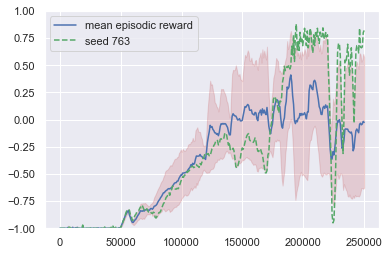

In [19]:
%matplotlib inline
plot_mean_std("ly57jevlQXe42Q9sKmBYzQ", add_best=True, save_path="dqn_exp_A")

Note the high standard deviation across the random seeds. Five runs where executed and their average performance is an episodic reward around 0. The best model (seed 763) solved the environment satisfactorily given the reward specification.

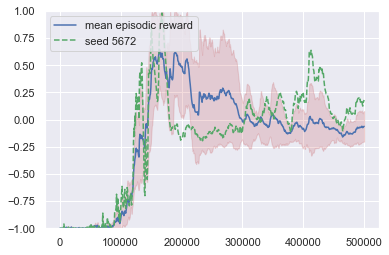

In [24]:
plot_mean_std("KNTboySEQBKjTEnG7X8OKA", add_best=True, save_path="dqn_exp_A_lleps")

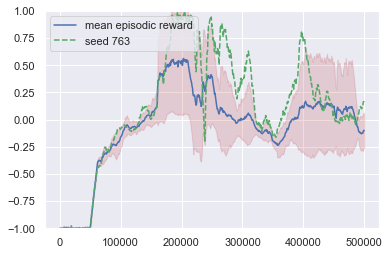

In [25]:
plot_mean_std("2njnXgbgQOGaWp1v292s7w", add_best=True, save_path="dqn_exp_A_loweps")

In [36]:
model_1 = model_path_prefix + "exp_001/tensor_obs/dqn/algo_default/seed_3377.zip"

Agent walks to the goal tile. Let's visualize it's policy on this version of the environment:

In [37]:
test_suite_model(model_1)

INFO: Beginning execution of test suite.
Path: exp_001/tensor_obs/dqn/algo_default/seed_3377.zip

Agent success on deterministic training environment:
Episode summary -> success: False, cumulative reward: 0, number of steps: 150

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [^] [>] [v] [v] [v] [v] [v] [v] [#]  1 
[#] [~] [v] [^] [v] [v] [v] [v] [v] [v] [#]  2 
[#] [x] [v] [>] [>] [v] [^] [v] [^] [v] [#]  3 
[#] [~] [^] [~] [>] [^] [^] [^] [^] [>] [#]  4 
[#] [~] [^] [~] [>] [v] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [>] [^] [~] [^] [^] [^] [#]  6 
[#] [~] [^] [~] [>] [^] [>] [^] [^] [^] [#]  7 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  8 
[#] [~] [^] [v] [^] [^] [v] [^] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 18.0 % on 50 random-goal episodes
Adjusted goal randomization success rat

**Explanation of output:**

- `[~]` is lava
- `[#]` is a wall
- `[x]` is the goal tile
- `<,^,>,v` are the directions the agent would take from that cell

The agent successfully navigates the environment from most positions, it quickly finds the goal tile and mostly doesn't take any detours. Exceptions are (9,5), (9,6), where the agent prefers to move against the wall (in this case not moving at all). The agent does not always walk the quickest paht, but considering that the reward model of `exp_001` does not incentivize the agent to find the shortest path (no time penalty), this is not especially surprising.
One can also observe that in no case would the agent walk in one of the lava tiles.

From the goal randomization summary, it can be concluded that the agent has no generalization capabilities whatsoever. In 50 episodes with random goal tile placements (guaranteed to be accessible), the agent success rate is 0.

As an example, the next cell shows the agent interaction when the goal tile is placed at the top right corner:

In [11]:
print(visualize_policy(model_1, upper_right_goal_env()))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [<] [<] [<] [<] [<] [>] [x] [#]  1 
[#] [~] [v] [<] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [~] [>] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [v] [~] [^] [<] [<] [<] [<] [>] [#]  4 
[#] [~] [v] [~] [^] [<] [~] [>] [>] [>] [#]  5 
[#] [~] [v] [~] [^] [<] [~] [>] [>] [>] [#]  6 
[#] [~] [v] [~] [>] [<] [>] [>] [>] [>] [#]  7 
[#] [~] [^] [~] [v] [<] [>] [>] [>] [>] [#]  8 
[#] [~] [>] [<] [<] [<] [<] [>] [>] [>] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



The agent oscillates between the starting position (2,9) and the adjacent tile to the right. It seems confused about the changed environment. Two factors seem to come into play: The goal tile was changed to (9,9) and the old goal tile was replaced with a lava tile. The agent might have recognized that its previous strategy might no longer be safe. Given the policy visualization for this environment version, this is further evidenced by the fact that the agent still tries to avoid all lava tiles, even the new lava tile at (1,3).
Let's see how the agent behaviour changes when the original goal tile is turned to floor.

In [12]:
print(visualize_policy(model_1, custom_env=alt_upper_right_goal_env()))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [<] [<] [<] [<] [<] [<] [x] [#]  1 
[#] [~] [v] [<] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [v] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [<] [<] [<] [<] [<] [#]  4 
[#] [~] [^] [~] [^] [<] [~] [>] [<] [>] [#]  5 
[#] [~] [^] [~] [^] [<] [~] [>] [>] [>] [#]  6 
[#] [~] [^] [~] [^] [<] [>] [<] [<] [>] [#]  7 
[#] [~] [^] [~] [v] [<] [<] [<] [>] [>] [#]  8 
[#] [~] [>] [<] [<] [<] [<] [<] [>] [>] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



We see that the agent still oscillates at the starting position and its right neighbour, however, its policy would lead the agent to walk to the original goal position when placed in most other cells (and then terminating the episode by walking in the lava tile below). Note that no policy-induced trajectory would end up in the actual goal tile given this environment.




Next, I'd like to see if the agent is able to avoid _newly placed_ lava tiles. Let's see two examples:

In [13]:
blocking_lava = original_lava() + [(2,8)]
env = make_env(
    lava_positions=blocking_lava
)
print(visualize_policy(model_1, custom_env=env))

blocking_lava = original_lava() + [(2,4)]
env = make_env(
    lava_positions=blocking_lava
)
print(visualize_policy(model_1, custom_env=env))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [<] [<] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [<] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [<] [<] [<] [<] [<] [#]  4 
[#] [~] [v] [~] [^] [<] [~] [^] [<] [<] [#]  5 
[#] [~] [^] [~] [^] [<] [~] [^] [<] [<] [#]  6 
[#] [~] [v] [~] [^] [<] [<] [<] [<] [<] [#]  7 
[#] [~] [~] [~] [v] [<] [<] [<] [<] [<] [#]  8 
[#] [~] [^] [<] [<] [<] [<] [<] [<] [<] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [<] [<] [v] [v] [v] [^] [^] [#]  1 
[#] [~] [v] [<] [<] [v] [v] [v] [v] [v] [#]  2 
[#] [x] [v] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [~] [~] [^] [<] [<] [^] [^] [^] [#]  4 
[#] [~] [^] [~] [^] [<] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  6 
[#] [~] [^] [~] [^] [^] [<] [^] [^] [^] [#

It seems that the agent is not able to grasp the inherent danger of lava tiles. It only evades the lava tile positions that it already knows from training. It seems the agent has not learned the causation between lava and negative reward but instead learned the correlation between the positions (of lava tiles during training) in the gridworld and the negative reward. This would also explain why changing the starting position does not confuse the agent in searching the goal tile (when it is at the original position). During training, only one part of the observation tensor is constantly changing, namely the agent's position.

**Summary:**

- During training, the agent learned to walk to the goal tile successfully
- When placed in the training environment, the trained model is able to find the goal tile from almost all starting positions
- However, the agent is not able to generalize this knowledge to goal tiles with other positions
- Only lava tiles known from training are circumvented by the agent

#### DQN dqn_slow_learning

Next, let's load `dqn_slow_learning` on exp_001. It was trained for 1m timesteps and is taken as a negative example. Model performance at the end of the training was a bit below 0. After some surges in performance around 200k-300k time steps, the agents across all random seeds forget their initial performance and slowly converge to a local minimum around 0. One such policy is visualized below.

In [14]:
model_2 = model_path_prefix + "exp_001/tensor_obs/dqn/dqn_slow_learning/seed_4744.zip"

In [15]:
test_suite_model(model_2)

INFO: Beginning execution of test suite.
Path: exp_001/tensor_obs/dqn/dqn_slow_learning/seed_4744.zip

Agent success on deterministic training environment:
Episode summary -> success: False, cumulative reward: 0, number of steps: 150

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [>] [>] [>] [>] [>] [v] [>] [>] [#]  1 
[#] [~] [>] [>] [>] [>] [>] [>] [>] [>] [#]  2 
[#] [x] [^] [>] [>] [>] [>] [>] [>] [>] [#]  3 
[#] [~] [^] [~] [>] [>] [^] [>] [>] [>] [#]  4 
[#] [~] [^] [~] [>] [^] [~] [>] [>] [>] [#]  5 
[#] [~] [v] [~] [>] [v] [~] [>] [>] [>] [#]  6 
[#] [~] [v] [~] [>] [>] [>] [>] [>] [>] [#]  7 
[#] [~] [v] [~] [>] [>] [>] [>] [>] [>] [#]  8 
[#] [~] [>] [>] [>] [>] [>] [>] [>] [>] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization succes

Interestingly, the agent seems to be able to find goals when they are on the x=2 axis. However, this can hardly be labelled as generalization capability given that the agent is not even able to solve the environment for which it was trained. (However, it is possible that the neural network attributes some relevance to placement of goal tiles.) This is not further investigated due to the reason stated above.

#### Goal randomization

Goal randomization with 2% random-goal episodes

```json
    "exp_001_goal_rnd_2" : {
        "max_steps" : 150,
        "slip_proba" : 0,
        "wall_rebound" : false,
        "spiky_active" : false,
        "reward_spec" : {
            "step_penalty" : 0,
            "goal_reward" : 1,
            "absorbing_states" : false,
            "absorbing_reward_goal" : 0,
            "absorbing_reward_lava" : -1,
            "risky_tile_reward" : 0,
            "lava_reward" : -1
        },
        "goal_rnd" : 0.02
    }
```

First I analyze one of the tensor_obs agents which was trained on `dqn_low_eps` for a million time steps. Some agents are successul during training but forget their capabilities later on.

In [16]:
model_3 = model_path_prefix + "exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_5672.zip"

In [17]:
test_suite_model(model_3, 100)

INFO: Beginning execution of test suite.
Path: exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_5672.zip

Agent success on deterministic training environment:
Episode summary -> success: True, cumulative reward: 1, number of steps: 7

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [^] [<] [<] [<] [>] [v] [<] [<] [#]  1 
[#] [~] [>] [<] [<] [<] [<] [<] [v] [<] [#]  2 
[#] [x] [<] [>] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [<] [>] [<] [<] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [<] [<] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [<] [>] [#]  6 
[#] [~] [^] [~] [^] [<] [>] [<] [<] [<] [#]  7 
[#] [~] [^] [~] [^] [<] [>] [>] [<] [>] [#]  8 
[#] [~] [^] [>] [>] [>] [<] [<] [<] [<] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 18.0 % on 100 random-goal episodes
Adjusted goal randomization suc

The other agents with the given configuration failed this run with negative rewards, therefore no further investigation.

In [18]:
# testing the best model (provided by save_best callback):
model_3_best = model_path_prefix + "exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_4744_best_model/best_model.zip"

In [19]:
test_suite_model(model_3_best, 50)

INFO: Beginning execution of test suite.
Path: exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_4744_best_model/best_model.zip

Agent success on deterministic training environment:
Episode summary -> success: True, cumulative reward: 1, number of steps: 7

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [<] [<] [v] [<] [v] [^] [<] [#]  1 
[#] [~] [v] [<] [<] [<] [<] [>] [<] [<] [#]  2 
[#] [x] [<] [>] [<] [<] [^] [<] [>] [<] [#]  3 
[#] [~] [^] [~] [>] [<] [>] [<] [<] [^] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [v] [<] [#]  5 
[#] [~] [^] [~] [>] [<] [~] [>] [<] [<] [#]  6 
[#] [~] [^] [~] [>] [v] [<] [>] [<] [<] [#]  7 
[#] [~] [^] [~] [>] [^] [<] [<] [<] [<] [#]  8 
[#] [~] [^] [<] [<] [<] [<] [<] [<] [<] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted g

Solves environment but no notable goal generalization capabilities

Next, let's look at the saved models for all 5 seeds with `dqn_low_eps` on `exp_001_goal_rnd_2`

In [20]:
rndm1 = model_path_prefix + "exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_3377_best_model/best_model.zip"
print(f"--- seed 3377 ---")
randomized_goal_stats(rndm1)
rndm2 = model_path_prefix + "exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_4267_best_model/best_model.zip"
print(f"--- seed 4267 ---")
randomized_goal_stats(rndm2)
rndm3 = model_path_prefix + "exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_4744_best_model/best_model.zip"
print(f"--- seed 4744 ---")
randomized_goal_stats(rndm3)
rndm4 = model_path_prefix + "exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_5672_best_model/best_model.zip"
print(f"--- seed 5672 ---")
randomized_goal_stats(rndm4)
rndm5 = model_path_prefix + "exp_001_goal_rnd_2/tensor_obs/dqn/dqn_low_eps/seed_763_best_model/best_model.zip"
print(f"--- seed 763 ---")
randomized_goal_stats(rndm5)

--- seed 3377 ---
Goal randomization success rate: 4.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 2.9 %
Goal randomization mean episode length: 135.46 
Goal positions with successes (unique): {(2, 8)}
--- seed 4267 ---
Goal randomization success rate: 22.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 20.0 %
Goal randomization mean episode length: 118.18 
Goal positions with successes (unique): {(8, 4), (9, 9), (4, 9), (8, 9), (7, 5), (6, 9), (2, 8)}
--- seed 4744 ---
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 14.3 %
Goal randomization mean episode length: 129.46 
Goal positions with successes (unique): {(2, 4), (2, 7), (2, 3), (2, 5), (2, 8)}
--- seed 5672 ---
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals

No notable successes.

Goal randomization with 5 % random-goal episodes:

```json
    "exp_001_goal_rnd_5" : {
        "max_steps" : 150,
        "slip_proba" : 0,
        "wall_rebound" : false,
        "spiky_active" : false,
        "reward_spec" : {
            "step_penalty" : 0,
            "goal_reward" : 1,
            "absorbing_states" : false,
            "absorbing_reward_goal" : 0,
            "absorbing_reward_lava" : -1,
            "risky_tile_reward" : 0,
            "lava_reward" : -1
        },
        "goal_rnd" : 0.05
    }
```

As this environment configuration has 5 % random-goal episodes during training (more than double the last configuration), we might see better goal generalization capabilities.
Unfortunately, these experiments did not yield any of the anticipated results. Mean episodic reward reaches a maximum for all runs at around 200k-400k steps.

In [21]:
model_4 = model_path_prefix + "exp_001_goal_rnd_5/tensor_obs/dqn/dqn_low_eps/seed_5672_best_model/best_model.zip"

In [22]:
test_suite_model(model_4)

INFO: Beginning execution of test suite.
Path: exp_001_goal_rnd_5/tensor_obs/dqn/dqn_low_eps/seed_5672_best_model/best_model.zip

Agent success on deterministic training environment:
Episode summary -> success: False, cumulative reward: 0, number of steps: 150

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [v] [v] [v] [v] [v] [#]  1 
[#] [~] [v] [v] [v] [v] [v] [v] [v] [v] [#]  2 
[#] [x] [v] [v] [v] [v] [v] [v] [v] [v] [#]  3 
[#] [~] [v] [~] [v] [v] [v] [v] [v] [v] [#]  4 
[#] [~] [v] [~] [v] [v] [~] [v] [v] [v] [#]  5 
[#] [~] [^] [~] [v] [v] [~] [v] [v] [v] [#]  6 
[#] [~] [^] [~] [^] [<] [<] [v] [v] [v] [#]  7 
[#] [~] [^] [~] [v] [<] [v] [v] [v] [v] [#]  8 
[#] [~] [v] [<] [<] [<] [<] [<] [<] [>] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjuste

### A2C on `exp_001`

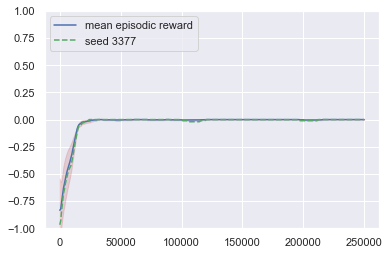

In [20]:
plot_mean_std("lFLmj6sdRiqOoZ2ARZgbZg", save_path="a2c_exp_A", add_best=True)

In [12]:
a2c_exp_A = model_path_prefix + "exp_001/tensor_obs/a2c/algo_default/seed_763.zip"
test_suite_model(a2c_exp_A)

INFO: Beginning execution of test suite.
Path: exp_001/tensor_obs/a2c/algo_default/seed_763.zip

Agent success on deterministic training environment:
Episode summary -> success: False, cumulative reward: 0, number of steps: 150

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [>] [>] [>] [>] [>] [>] [>] [>] [#]  1 
[#] [~] [>] [>] [>] [>] [>] [>] [>] [>] [#]  2 
[#] [x] [>] [>] [>] [>] [>] [>] [>] [>] [#]  3 
[#] [~] [>] [~] [>] [>] [>] [>] [>] [>] [#]  4 
[#] [~] [>] [~] [>] [>] [~] [>] [>] [>] [#]  5 
[#] [~] [>] [~] [>] [>] [~] [>] [>] [>] [#]  6 
[#] [~] [>] [~] [>] [>] [>] [>] [>] [>] [#]  7 
[#] [~] [>] [~] [>] [>] [>] [>] [>] [>] [#]  8 
[#] [~] [>] [>] [>] [>] [>] [>] [>] [>] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate

In [15]:
# testing whether pixel a2c agents learned the same behavioral bias than tensor agents on exp A
# They all move in exactly one direction
a2c_pixel_exp_A = model_path_prefix + "exp_001/pixel_obs_8/a2c/algo_default/seed_2819"
test_suite_model(a2c_pixel_exp_A)

INFO: Beginning execution of test suite.
Path: exp_001/pixel_obs_8/a2c/algo_default/seed_2819

Agent success on deterministic training environment:
Episode summary -> success: False, cumulative reward: 0, number of steps: 150

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [v] [v] [v] [v] [v] [#]  1 
[#] [~] [v] [v] [v] [v] [v] [v] [v] [v] [#]  2 
[#] [x] [v] [v] [v] [v] [v] [v] [v] [v] [#]  3 
[#] [~] [v] [~] [v] [v] [v] [v] [v] [v] [#]  4 
[#] [~] [v] [~] [v] [v] [~] [v] [v] [v] [#]  5 
[#] [~] [v] [~] [v] [v] [~] [v] [v] [v] [#]  6 
[#] [~] [v] [~] [v] [v] [v] [v] [v] [v] [#]  7 
[#] [~] [v] [~] [v] [v] [v] [v] [v] [v] [#]  8 
[#] [~] [v] [v] [v] [v] [v] [v] [v] [v] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 0.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on

To begin with, it is important to note that finding a good hyperparameter configuration was the hardest challenge in training a2c-agents on my Gridworld implementation. Initial runs with a2c default configurations have not produced any acceptable (for lack of a better word) results - independent of environment configuration.
In all cases, a2c defaults led to agents that were suboptimal and quickly converged to local optima. In some cases, this would have been quickly stepping into lava tiles as to avoid higher penalties when indefinitely navigating the environment. In other cases with no time penalties, the agents also indefinitely navigated the environment in a task presumed to be the avoidance of lava tiles - which is naturally better than to fall into them - but led to agents that didn't explore their environment for higher-rewarding solutions. A specific hyperparameter of the a2c algorithm, however, proved to be pivotal in the agent's ability to explore the environment and increase its performance when training.

- [ ] TODO Why does the entropy regularization have such an effect (what does it do?)

Based on my experiments (also confirming the findings of Leike et al. in "AI Safety Gridworlds"), it has proven sufficient to only tweak the entropy regularization parameter. This parameter has completely dominated the effects on training performance and the agent's ability to step out of local optima. Very small adjustments to this parameter can have an important impact on training performance, which indicates that one's training success might depend on systematic optimization of only this parameter. Other parameters could help fine-tuning at la later stage.

In my experience during this Bachelor's thesis, I noticed a Trade-off between training stability and variance in performance vs the need for hyperparameter optimization but stability and low variance (DQN vs A2C)
Below are some expamples of only changing the entropy parameter and the impact this has on training performance.

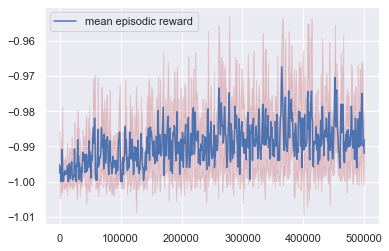

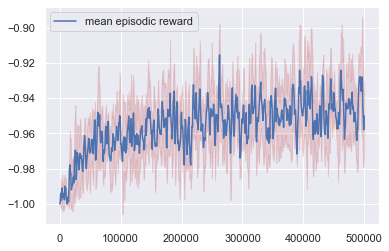

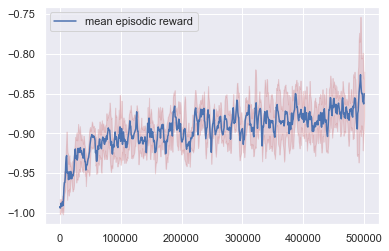

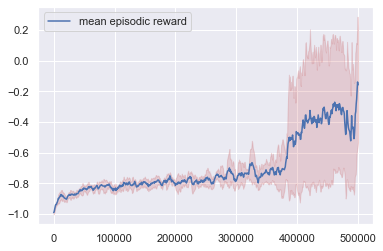

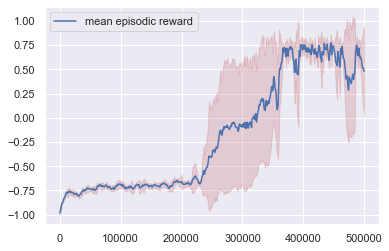

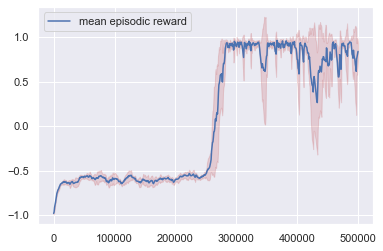

In [23]:
plot_mean_std("nsVm5pO8RrirkG8WTO4I0A", save_path="a2c_exp001_entropy_impact_2") # entropy_2 (0.4)
plot_mean_std("R9HyyQqCQZaGA7wacmM1FA", save_path="a2c_exp001_entropy_impact_1") # entropy_1 (0.2)
plot_mean_std("4s79H1HMQlSMYLag4z6Oig", save_path="a2c_exp001_entropy_impact_5") # entropy_5 (0.1)
plot_mean_std("Xipi9FmbRKKVbRyJhMsqAg", save_path="a2c_exp001_entropy_impact_4") # entropy_4 (0.05)
plot_mean_std("p8Jy5osVTMK9vDP9AkYqSg", save_path="a2c_exp001_entropy_impact_3") # entropy_3 (0.025)
plot_mean_std("H4WJlvj4RKWYZo0Bn9rbqA", save_path="a2c_exp001_entropy_impact_6") # entropy_6 (0.0125)--> best configuration!

These different plots show the impact the entropy regularization parameter can have on training. Only the last set of runs with an entropy parameter of `0.0125` was succesful. A2C defaults set the entropy regularization at 0.

Let's load an a2c model that was very succesful during training (one of a2c_entropy_6). It was trained for 500k time steps The next observation is an interesting one:

In [116]:
a2c_model_1 = model_path_prefix + "exp_001/tensor_obs/a2c/a2c_entropy_6/seed_4267.zip"

test_suite_model(a2c_model_1)

INFO: Beginning execution of test suite.
Path: exp_001/tensor_obs/a2c/a2c_entropy_6/seed_4267.zip

Agent success on deterministic training environment:
Episode summary -> success: True, cumulative reward: 1, number of steps: 7

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [^] [^] [^] [^] [^] [^] [^] [#]  1 
[#] [~] [v] [<] [^] [^] [^] [^] [^] [^] [#]  2 
[#] [x] [<] [^] [^] [^] [^] [^] [^] [^] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  6 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  7 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  8 
[#] [~] [^] [<] [^] [^] [^] [^] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate 

In [118]:
print(visualize_policy(a2c_model_1, custom_env=make_env(
        goal_positions=[(3,3)],
        lava_positions=original_lava()
    )
))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [^] [^] [^] [^] [^] [^] [^] [#]  1 
[#] [~] [v] [<] [^] [^] [^] [^] [^] [^] [#]  2 
[#] [^] [<] [x] [^] [^] [^] [^] [^] [^] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  6 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  7 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  8 
[#] [~] [^] [<] [^] [^] [^] [^] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



**Goal misgeneralization, same path:** Agent still walks to the same location

**Distributional Shift, Goal Misgeneralization:**
The agent does not understand that the important tile is the goal tile. It still navigates to the position in which it recieved positive rewards during training. Once the state distribution shifts, the agent is not able to apply the learned skills to a simple alteration of the environment. This shows that the state representation during training is not truly sufficient if we want the agent to be able to generalize knowledge. It must be confronted with more diverse data. Perfect example of goal misgeneralization: agent has learned a *directional/location proxy* of the intended objective which is to find the goal tile. What is even more interesting: the agent would walk upwards from almost all other positions, which means it would not even be able to generalize its skills to other starting positions, as the DQN agent could.

- This very poor generalization might be a good showcase of how the different algorithms work and learn: When looking at the mean episodic reward during the a2c agent's training, one immediately recognizes that it abruptly gets better around 250k-275k time steps (across all 5 random seeds) 
- [ ] TODO Then analysis with epsilon-greedy exploration vs actor-critic entropy update and local optimum in which it stays in a very stable manner

**Note:** Goal randomization reports a success rate of 14 %. This is expected and does not hint at possible goal generalization capabilities. 14% implies 7 successes out of 50 episodes and we know that the agent always takes the same path to the same location. There are 7 tiles on that path that can be subject to goal randomization (63 tiles are eligible for goal randomization in this setting) which means that we would expect ~11% of the random goals to land on this path. As such, 14% is not a significant deviation. We also see that the mean episode length is 6.48, which implies the agent was stopped early on its intended route which takes 7 steps (until in lava, when goal is not at original location).

#### Goal Randomization on exp_001

I successively applied a higher percentage of goal randomization for training episodes to `exp_001` in order to find out how the generalization capabilities of the agents were influenced.
First, two baselines must be established:

- An agent that always follows the optimal policy on the original env (reward-optimal policy: shortest path to the goal state in `exp_001` as there is no slipping factor)
- An agent that always follows a uniform random policy 

Both of these baselines will attain a certain percentage of goal generalization capabilities, therefore, only a an agent who's performance across goal-randomized environments significantly deviates from the baselines can be called "goal-generalizing"

In [65]:
randomization_performances = {"gen_perf_unique_mean" : [], "gen_perf_unique_std" : []}

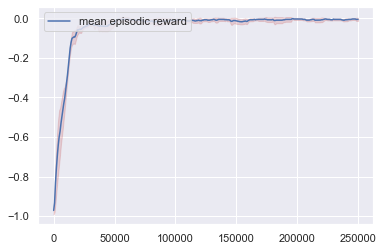

--- seed_3377.zip ---
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 11.4 %
Goal randomization mean episode length: 129.74 
Goal positions with successes (unique): {(4, 9), (8, 9), (6, 9), (9, 9)}
--- seed_763.zip ---
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 11.4 %
Goal randomization mean episode length: 129.74 
Goal positions with successes (unique): {(4, 9), (8, 9), (6, 9), (9, 9)}
--- seed_5672.zip ---
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 11.4 %
Goal randomization mean episode length: 129.74 
Goal positions with successes (unique): {(4, 9), (8, 9), (6, 9), (9, 9)}
--- seed_4744.zip ---
Goal randomization success rate: 14.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique differ

In [51]:
# TODO ERSETZEN, PLACEHOLDER
plot_mean_std("HDhmTnnYSGKvHMfZr86gwg")
m1 = model_path_prefix + "exp_001/pixel_obs_8/a2c/algo_default/seed_3377.zip"
m2 = model_path_prefix + "exp_001/pixel_obs_8/a2c/algo_default/seed_763.zip"
m3 = model_path_prefix + "exp_001/pixel_obs_8/a2c/algo_default/seed_5672.zip"
m4 = model_path_prefix + "exp_001/pixel_obs_8/a2c/algo_default/seed_4744.zip"
m5 = model_path_prefix + "exp_001/pixel_obs_8/a2c/algo_default/seed_4267.zip"
print("---", m1.split("/")[-1], "---")
randomized_goal_stats(m1)
print("---", m2.split("/")[-1], "---")
randomized_goal_stats(m2)
print("---", m3.split("/")[-1], "---")
randomized_goal_stats(m3)
print("---", m4.split("/")[-1], "---")
randomized_goal_stats(m4)
print("---", m5.split("/")[-1], "---")
randomized_goal_stats(m5)

Every agent seems to have learned the exact same policy. Without entropy regularization, the agents are quickly converging to local optima

In [66]:
randomization_performances["gen_perf_unique_mean"].append(11.4)
randomization_performances["gen_perf_unique_std"].append(0) # no deviation

The next model is an a2c-agent trained on the entropy_6 + `exp_001_goal_rnd_2` configuration for 1m time steps on pixel observations

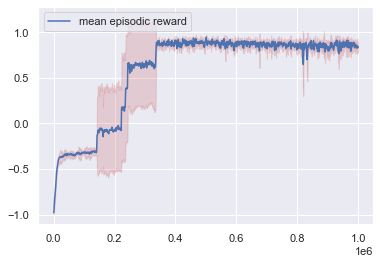

In [25]:
plot_mean_std("9MU7GPArRXC16hgJDRygGA")

Looks like a step function because the abrupt training performance surge came at different points in time for all runs. The plotted curve shows that the agents are able to solve the environment successfully, with mean episodic rewards close to the optimal solution of 1. The a2c configuration leads to stable training across all runs.

In [26]:
pixel_model_rnd2 = model_path_prefix + "exp_001_goal_rnd_2/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip"

In [27]:
test_suite_model(pixel_model_rnd2)

INFO: Beginning execution of test suite.
Path: exp_001_goal_rnd_2/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip

Agent success on deterministic training environment:
Episode summary -> success: True, cumulative reward: 1, number of steps: 7

Policy visualization on training environment:
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [<] [<] [<] [<] [^] [^] [#]  1 
[#] [~] [v] [v] [<] [<] [<] [<] [^] [^] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [^] [#]  3 
[#] [~] [^] [~] [^] [<] [<] [^] [<] [^] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [<] [<] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [<] [<] [#]  6 
[#] [~] [^] [~] [^] [<] [<] [<] [<] [<] [#]  7 
[#] [~] [^] [~] [^] [<] [<] [<] [<] [<] [#]  8 
[#] [~] [^] [<] [<] [^] [<] [^] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
Goal randomization success rate: 20.0 % on 50 random-goal episodes
Adjusted goal randomization s

Let's see what generalization capabilities have been developed across different random seeds:

In [28]:
# Cell put in raw mode due to high computational cost
# (output should always be identical due to random seed resetting)
m1 = model_path_prefix + "exp_001_goal_rnd_2/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip"
m2 = model_path_prefix + "exp_001_goal_rnd_2/pixel_obs_8/a2c/a2c_entropy_6/seed_763.zip"
m3 = model_path_prefix + "exp_001_goal_rnd_2/pixel_obs_8/a2c/a2c_entropy_6/seed_5672.zip"
m4 = model_path_prefix + "exp_001_goal_rnd_2/pixel_obs_8/a2c/a2c_entropy_6/seed_4744.zip"
m5 = model_path_prefix + "exp_001_goal_rnd_2/pixel_obs_8/a2c/a2c_entropy_6/seed_4267.zip"
print("---", m1.split("/")[-1], "---")
randomized_goal_stats(m1)
print("---", m2.split("/")[-1], "---")
randomized_goal_stats(m2)
print("---", m3.split("/")[-1], "---")
randomized_goal_stats(m3)
print("---", m4.split("/")[-1], "---")
randomized_goal_stats(m4)
print("---", m5.split("/")[-1], "---")
randomized_goal_stats(m5)

--- seed_3377.zip ---
Goal randomization success rate: 20.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 20.0 %
Goal randomization mean episode length: 121.16 
Goal positions with successes (unique): {(2, 4), (7, 1), (2, 7), (4, 2), (2, 5), (4, 1), (2, 8)}
--- seed_763.zip ---
Goal randomization success rate: 20.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 22.9 %
Goal randomization mean episode length: 106.64 
Goal positions with successes (unique): {(2, 4), (2, 8), (2, 7), (4, 9), (2, 3), (2, 2), (2, 5), (5, 2)}
--- seed_5672.zip ---
Goal randomization success rate: 38.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 42.9 %
Goal randomization mean episode length: 97.06 
Goal positions with successes (unique): {(8, 8), (6, 2), (8, 4), (2, 2), (4, 9), (8, 7), (5, 7), (4, 2), (8, 3), (7, 6), (8, 6), (7, 2), (7, 5), (4, 7), (5, 2)}
---

In [67]:
a=np.mean([20, 22.9, 42.9, 8.6, 0])
b=np.std([20, 22.9, 42.9, 8.6, 0])
randomization_performances["gen_perf_unique_mean"].append(a)
randomization_performances["gen_perf_unique_std"].append(b)

`exp_001_goal_rnd_5`
Let's test randomization capabilities with 5 % randomization

In [29]:
# Cell put in raw mode due to high computational cost
# (output should always be identical due to random seed resetting)
m1 = model_path_prefix + "exp_001_goal_rnd_5/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip"
m2 = model_path_prefix + "exp_001_goal_rnd_5/pixel_obs_8/a2c/a2c_entropy_6/seed_763.zip"
m3 = model_path_prefix + "exp_001_goal_rnd_5/pixel_obs_8/a2c/a2c_entropy_6/seed_5672.zip"
m4 = model_path_prefix + "exp_001_goal_rnd_5/pixel_obs_8/a2c/a2c_entropy_6/seed_4744.zip"
m5 = model_path_prefix + "exp_001_goal_rnd_5/pixel_obs_8/a2c/a2c_entropy_6/seed_4267.zip"
print("---", m1.split("/")[-1], "---")
randomized_goal_stats(m1)
print("---", m2.split("/")[-1], "---")
randomized_goal_stats(m2)
print("---", m3.split("/")[-1], "---")
randomized_goal_stats(m3)
print("---", m4.split("/")[-1], "---")
randomized_goal_stats(m4)
print("---", m5.split("/")[-1], "---")
randomized_goal_stats(m5)

--- seed_3377.zip ---
Goal randomization success rate: 30.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 28.6 %
Goal randomization mean episode length: 106.46 
Goal positions with successes (unique): {(2, 4), (2, 7), (9, 9), (2, 3), (8, 9), (5, 6), (2, 2), (2, 5), (4, 7), (2, 8)}
--- seed_763.zip ---
Goal randomization success rate: 32.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 34.3 %
Goal randomization mean episode length: 103.62 
Goal positions with successes (unique): {(8, 8), (2, 4), (2, 7), (4, 9), (2, 3), (8, 9), (7, 6), (8, 6), (2, 2), (2, 5), (6, 9), (2, 8)}
--- seed_5672.zip ---
Goal randomization success rate: 46.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 48.6 %
Goal randomization mean episode length: 83.34 
Goal positions with successes (unique): {(8, 8), (2, 4), (2, 7), (4, 9), (8, 7), (5, 7), (2, 3), (4, 5), (8,

In [68]:
a=np.mean([28.6, 34.3, 48.6, 17.1, 20])
b=np.std([28.6, 34.3, 48.6, 17.1, 20])
randomization_performances["gen_perf_unique_mean"].append(a)
randomization_performances["gen_perf_unique_std"].append(b)

In [30]:
print("mean:", sum([28.6, 34.3, 48.6, 17.1, 20])/5)

mean: 29.72


Range of 20 - 48.6 % generalization capabilities. We can see, that even though A2C seems comparably stable in training and there is less variance, the range of goal generalization capabilities is still high.

10 % goal randomization on `exp_001_goal_rnd_10`

In [31]:
m1 = model_path_prefix + "exp_001_goal_rnd_10/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip"
m2 = model_path_prefix + "exp_001_goal_rnd_10/pixel_obs_8/a2c/a2c_entropy_6/seed_763.zip"
m3 = model_path_prefix + "exp_001_goal_rnd_10/pixel_obs_8/a2c/a2c_entropy_6/seed_5672.zip"
m4 = model_path_prefix + "exp_001_goal_rnd_10/pixel_obs_8/a2c/a2c_entropy_6/seed_4744.zip"
m5 = model_path_prefix + "exp_001_goal_rnd_10/pixel_obs_8/a2c/a2c_entropy_6/seed_4267.zip"
print("---", m1.split("/")[-1], "---")
randomized_goal_stats(m1)
print("---", m2.split("/")[-1], "---")
randomized_goal_stats(m2)
print("---", m3.split("/")[-1], "---")
randomized_goal_stats(m3)
print("---", m4.split("/")[-1], "---")
randomized_goal_stats(m4)
print("---", m5.split("/")[-1], "---")
randomized_goal_stats(m5)

--- seed_3377.zip ---
Goal randomization success rate: 54.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 60.0 %
Goal randomization mean episode length: 72.76 
Goal positions with successes (unique): {(3, 1), (5, 4), (9, 2), (5, 7), (8, 3), (8, 9), (2, 2), (2, 5), (2, 8), (7, 1), (4, 5), (5, 6), (5, 3), (2, 4), (2, 7), (4, 7), (5, 2), (5, 5), (8, 4), (2, 3), (7, 5)}
--- seed_763.zip ---
Goal randomization success rate: 56.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 60.0 %
Goal randomization mean episode length: 70.06 
Goal positions with successes (unique): {(4, 9), (5, 4), (5, 1), (8, 9), (2, 8), (6, 2), (7, 1), (4, 2), (4, 5), (5, 3), (2, 4), (2, 7), (4, 1), (5, 2), (5, 5), (8, 4), (9, 9), (8, 7), (2, 3), (7, 5), (6, 9)}
--- seed_5672.zip ---
Goal randomization success rate: 84.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 80.0

In [69]:
a=np.mean([60, 60, 80, 85.7, 14.3])
b=np.std([60, 60, 80, 85.7, 14.3])
randomization_performances["gen_perf_unique_mean"].append(a)
randomization_performances["gen_perf_unique_std"].append(b)

15 % goal randomziation on `exp_001_goal_rnd_15`

In [32]:
m1 = model_path_prefix + "exp_001_goal_rnd_15/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip"
m2 = model_path_prefix + "exp_001_goal_rnd_15/pixel_obs_8/a2c/a2c_entropy_6/seed_763.zip"
m3 = model_path_prefix + "exp_001_goal_rnd_15/pixel_obs_8/a2c/a2c_entropy_6/seed_5672.zip"
m4 = model_path_prefix + "exp_001_goal_rnd_15/pixel_obs_8/a2c/a2c_entropy_6/seed_4744.zip"
m5 = model_path_prefix + "exp_001_goal_rnd_15/pixel_obs_8/a2c/a2c_entropy_6/seed_4267.zip"
print("---", m1.split("/")[-1], "---")
randomized_goal_stats(m1)
print("---", m2.split("/")[-1], "---")
randomized_goal_stats(m2)
print("---", m3.split("/")[-1], "---")
randomized_goal_stats(m3)
print("---", m4.split("/")[-1], "---")
randomized_goal_stats(m4)
print("---", m5.split("/")[-1], "---")
randomized_goal_stats(m5)

--- seed_3377.zip ---
Goal randomization success rate: 94.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 94.3 %
Goal randomization mean episode length: 16.44 
Goal positions with successes (unique): {(3, 1), (4, 9), (5, 4), (5, 1), (5, 7), (9, 2), (8, 3), (8, 9), (8, 6), (2, 2), (2, 8), (7, 1), (4, 2), (4, 5), (5, 6), (5, 3), (9, 7), (8, 8), (2, 4), (2, 7), (7, 6), (4, 1), (4, 7), (5, 2), (5, 5), (8, 4), (8, 1), (9, 9), (8, 7), (2, 3), (7, 2), (7, 5), (6, 9)}
--- seed_763.zip ---
Goal randomization success rate: 98.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 97.1 %
Goal randomization mean episode length: 10.48 
Goal positions with successes (unique): {(3, 1), (4, 9), (5, 4), (5, 1), (5, 7), (9, 2), (8, 3), (8, 9), (8, 6), (2, 2), (2, 5), (2, 8), (6, 2), (4, 2), (4, 5), (5, 6), (5, 3), (9, 7), (8, 8), (2, 4), (2, 7), (7, 6), (4, 1), (4, 7), (5, 2), (5, 5), (8, 4), (8, 1), (9, 9), (

In [70]:
a=np.mean([94.3, 97.1, 42.9, 0, 60])
b=np.std([94.3, 97.1, 42.9, 0, 60])
randomization_performances["gen_perf_unique_mean"].append(a)
randomization_performances["gen_perf_unique_std"].append(b)

Why is there a seed with 0 % goal randomization successes? Huge variance in generalization capabilities. Maybe it has something to do with the **lottery ticket hypothesis**?

NOICE: 20 % random episodes during training `exp_001_goal_rnd_20`

In [33]:
m_rnd_20 = model_path_prefix+ "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_763.zip"

In [91]:
m1 = model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip"
m2 = model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_763.zip"
m3 = model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_5672.zip"
m4 = model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_4744.zip"
m5 = model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_4267.zip"
print("---", m1.split("/")[-1], "---")
randomized_goal_stats(m1)
print("---", m2.split("/")[-1], "---")
randomized_goal_stats(m2)
print("---", m3.split("/")[-1], "---")
randomized_goal_stats(m3)
print("---", m4.split("/")[-1], "---")
randomized_goal_stats(m4)
print("---", m5.split("/")[-1], "---")
randomized_goal_stats(m5)

--- seed_3377.zip ---
Goal randomization success rate: 88.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 91.4 %
Goal randomization mean episode length: 25.08 
Goal positions with successes (unique): {(3, 1), (4, 9), (5, 4), (5, 1), (5, 7), (9, 2), (8, 3), (8, 9), (8, 6), (2, 2), (2, 5), (2, 8), (6, 2), (7, 1), (4, 2), (5, 3), (9, 7), (8, 8), (2, 4), (2, 7), (7, 6), (4, 1), (4, 7), (5, 2), (5, 5), (8, 4), (8, 1), (8, 7), (2, 3), (7, 2), (7, 5), (6, 9)}
--- seed_763.zip ---
Goal randomization success rate: 82.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 80.0 %
Goal randomization mean episode length: 27.7 
Goal positions with successes (unique): {(4, 9), (5, 4), (5, 1), (5, 7), (9, 2), (8, 3), (8, 6), (2, 2), (2, 8), (7, 1), (4, 2), (4, 5), (5, 6), (5, 3), (9, 7), (2, 4), (2, 7), (4, 1), (4, 7), (5, 2), (5, 5), (8, 4), (8, 1), (9, 9), (2, 3), (7, 2), (7, 5), (6, 9)}
--- seed_5672.zip 

In [71]:
a=np.mean([91.4, 80, 77.1, 74.3, 60])
b=np.std([91.4, 80, 77.1, 74.3, 60])
randomization_performances["gen_perf_unique_mean"].append(a)
randomization_performances["gen_perf_unique_std"].append(b)

These results show that goal randomization of 20% of episodes leads to an agent that confidently solves over 70% of random goals it is confronted with.

In [72]:
rnd_performances = pd.DataFrame(randomization_performances, index=[0, 2, 5, 10, 15, 20])
rnd_performances

,gen_perf_unique_mean,gen_perf_unique_std
0,11.40,0.000000
2,18.88,14.536217
5,29.72,11.246582
10,60.00,25.095737
15,58.86,35.885407
20,76.56,10.116244


Montecarlo simulation for random baseline: (model path does not matter except for extracting the environment)

In [103]:
randomized_goal_stats(model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_763.zip", monte_carlo=4)
randomized_goal_stats(model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_3377.zip", monte_carlo=12)
randomized_goal_stats(model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_5672.zip", monte_carlo=14)
randomized_goal_stats(model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_4744.zip", monte_carlo=9014)
randomized_goal_stats(model_path_prefix + "exp_001_goal_rnd_20/pixel_obs_8/a2c/a2c_entropy_6/seed_4267.zip", monte_carlo=41824)

Goal randomization success rate: 4.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 5.7 %
Goal randomization mean episode length: 4.5 
Goal positions with successes (unique): {(6, 9), (9, 9)}
Goal randomization success rate: 2.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 2.9 %
Goal randomization mean episode length: 3.76 
Goal positions with successes (unique): {(2, 8)}
Goal randomization success rate: 2.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 2.9 %
Goal randomization mean episode length: 4.22 
Goal positions with successes (unique): {(2, 8)}
Goal randomization success rate: 6.0 % on 50 random-goal episodes
Adjusted goal randomization success rate on unique different goals: 8.6 %
Goal randomization mean episode length: 3.6 
Goal positions with successes (unique): {(4, 9), (6, 9), (2, 8)}
Goal randomization success rate: 2.0 %

In [104]:
random_baseline = np.mean([5.7, 2.9,2.9,8.6, 2.9])

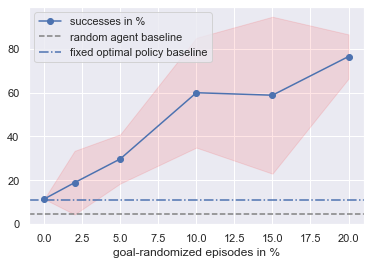

In [122]:
# random_baseline: montecarlo simulation on randomized_goal_stats
plt.plot(rnd_performances['gen_perf_unique_mean'], '-o', label="successes in %")
plt.axhline(random_baseline, 0, 20, linestyle="--", color="grey", label="random agent baseline")
plt.axhline(11, 0, 20, linestyle="-.", label="fixed optimal policy baseline") # recall cell with 11 % expected goal generalization when always walking same path
stdl = rnd_performances['gen_perf_unique_mean'] - rnd_performances['gen_perf_unique_std']
stdh = rnd_performances['gen_perf_unique_mean'] + rnd_performances['gen_perf_unique_std']
plt.fill_between(rnd_performances.index.values, stdl, stdh, color="red", alpha=0.1)
plt.xlabel("goal-randomized episodes in %")
plt.legend(loc="upper left")
plt.savefig("a2c_goal_rnd_graph.pdf", format="pdf")

## `time_penalty`

*Environment Configuration:*

```json
    "time_penalty" : {
        "max_steps" : 150,
        "slip_proba" : 0,
        "wall_rebound" : false,
        "spiky_active" : false,
        "reward_spec" : {
            "step_penalty" : -0.1,
            "goal_reward" : 1,
            "absorbing_states" : false,
            "absorbing_reward_goal" : 0,
            "absorbing_reward_lava" : -1,
            "risky_tile_reward" : 0,
            "lava_reward" : -1
        }
    }
```

### A2C on `time_penalty`

## Slipping Experiments

### `exp_slip_1`

_Environment Configuration:_

```json
    "exp_slip_1" : {
        "max_steps" : 150,
        "slip_proba" : 0.05,
        "wall_rebound" : false,
        "spiky_active" : false,
        "reward_spec" : {
            "step_penalty" : 0,
            "goal_reward" : 1,
            "absorbing_states" : false,
            "absorbing_reward_goal" : 0,
            "absorbing_reward_lava" : -1,
            "risky_tile_reward" : 0,
            "lava_reward" : -1
        }
    }
```

First, we need to know the optimal path.

- [ ] TODO

In [35]:
test_suite_model(model_path_prefix + "exp_slip_1/tensor_obs/dqn/dqn_low_eps/seed_4267_best_model/best_model")

INFO: Beginning execution of test suite.
Path: exp_slip_1/tensor_obs/dqn/dqn_low_eps/seed_4267_best_model/best_model

Agent success on deterministic training environment:
INFO: slipping probability removed; 
Episode summary -> success: True, cumulative reward: 1, number of steps: 7

Policy visualization on training environment:
INFO: slipping probability removed; 
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [<] [v] [v] [v] [v] [v] [#]  1 
[#] [~] [v] [<] [<] [<] [v] [v] [v] [v] [#]  2 
[#] [x] [<] [<] [<] [<] [^] [v] [v] [v] [#]  3 
[#] [~] [^] [~] [>] [^] [>] [v] [v] [v] [#]  4 
[#] [~] [^] [~] [>] [v] [~] [v] [v] [v] [#]  5 
[#] [~] [^] [~] [v] [v] [~] [v] [v] [v] [#]  6 
[#] [~] [^] [~] [v] [v] [v] [v] [v] [v] [#]  7 
[#] [~] [^] [~] [v] [<] [v] [v] [v] [v] [#]  8 
[#] [~] [^] [>] [^] [v] [v] [v] [v] [v] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
INFO: slipping 

In [36]:
test_suite_model(model_path_prefix + "exp_slip_1/pixel_obs_8/a2c/a2c_entropy_6/seed_5672")

INFO: Beginning execution of test suite.
Path: exp_slip_1/pixel_obs_8/a2c/a2c_entropy_6/seed_5672

Agent success on deterministic training environment:
INFO: slipping probability removed; 
Episode summary -> success: True, cumulative reward: 1, number of steps: 7

Policy visualization on training environment:
INFO: slipping probability removed; 
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [^] [v] [^] [^] [^] [^] [#]  1 
[#] [~] [v] [<] [<] [^] [^] [^] [<] [^] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [<] [<] [<] [<] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [<] [<] [#]  5 
[#] [~] [^] [~] [^] [<] [~] [^] [<] [<] [#]  6 
[#] [~] [^] [~] [^] [<] [>] [>] [v] [<] [#]  7 
[#] [~] [^] [~] [^] [^] [<] [<] [<] [<] [#]  8 
[#] [~] [^] [<] [<] [<] [<] [<] [<] [<] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
INFO: slipping probability removed

### `exp_slip_2`

_Environment Configuration:_

```json
    "exp_slip_2" : {
        "max_steps" : 150,
        "slip_proba" : 0.1,
        "wall_rebound" : false,
        "spiky_active" : false,
        "reward_spec" : {
            "step_penalty" : 0,
            "goal_reward" : 1,
            "absorbing_states" : false,
            "absorbing_reward_goal" : 0,
            "absorbing_reward_lava" : -1,
            "risky_tile_reward" : 0,
            "lava_reward" : -1
        }
    }
```

In [37]:
dqn_slip_2 = model_path_prefix + "exp_slip_2/tensor_obs/dqn/dqn_low_eps/seed_763_best_model/best_model"

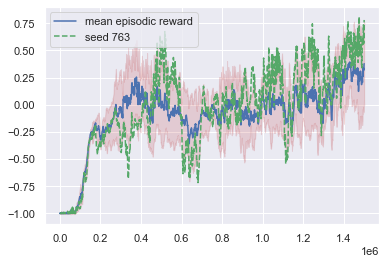

In [38]:
plot_mean_std("FBGYxl10To2yZF6gA8IGsg", add_best=True)

In [39]:
execute_episode(dqn_slip_2)
print(visualize_policy(dqn_slip_2))

INFO: slipping probability removed; 
Episode summary -> success: True, cumulative reward: 1, number of steps: 15
INFO: slipping probability removed; 
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [^] [^] [^] [^] [^] [^] [^] [^] [#]  1 
[#] [~] [v] [<] [<] [<] [<] [<] [^] [^] [#]  2 
[#] [x] [<] [<] [^] [<] [^] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [>] [^] [<] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [<] [<] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [<] [#]  6 
[#] [~] [^] [~] [^] [^] [<] [^] [<] [^] [#]  7 
[#] [~] [v] [~] [>] [^] [<] [<] [^] [<] [#]  8 
[#] [~] [>] [>] [>] [^] [^] [<] [<] [<] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



This agent is especially interesting, since it does not choose the shortest path to the goal location. This agent is thus much closer to the environments optimal solution. The policy value (starting state) for this agent is:

In [40]:
policy, solver_instance = RiskyPathSolver.convert_to_policy(dqn_slip_2)
print(solver_instance.evaluate_policy(policy)[(2,9)])

0.5269624379316038


Model-estimated action-value for starting state and following the policy-induced action:

In [41]:
model, env, _, _ = model_env_from_path(dqn_slip_2)
env = TensorObsWrapper(env)
compute_q_values(model.policy, env.reset())

INFO: slipping probability removed; 


tensor([[-1.0173,  0.6918,  0.7472,  0.6544]])

**Value for the optimal policy:** (value of the starting state)

In [42]:
optimal_policy = solver_instance.compute_optimal_policy()
solver_instance.evaluate_policy(optimal_policy)[(2,9)]

0.6352442315542554

The model attributes an action value of 0.7472 even though the starting state value of the optimal policy is 0.6352. This implies that the model's prediction is overly optimistic when compared with the actual policy evaluation.

In [43]:
# Comparing policies:
print(visualize_policy(dqn_slip_2))
print(solver_instance.visualize_policy(optimal_policy))

INFO: slipping probability removed; 
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [^] [^] [^] [^] [^] [^] [^] [^] [#]  1 
[#] [~] [v] [<] [<] [<] [<] [<] [^] [^] [#]  2 
[#] [x] [<] [<] [^] [<] [^] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [>] [^] [<] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [<] [<] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [<] [#]  6 
[#] [~] [^] [~] [^] [^] [<] [^] [<] [^] [#]  7 
[#] [~] [v] [~] [>] [^] [<] [<] [^] [<] [#]  8 
[#] [~] [>] [>] [>] [^] [^] [<] [<] [<] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [v] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [>] [^] [^] [#]  6 
[#] [

**NOTE:** Which path would be optimal for a different discount factor? Keep in mind that the optimal path can be influenced by discounting OR a time-step penalty in the reward model. Both lead to shorter paths being more rewarding, as penalties would be avoided and discounting leads to the need to experience positive rewards as soon as possible. The discount factor used in DQN and A2C is 0.99 but let's try to see how it affects different paths:

In [44]:
new_solver_1 = RiskyPathSolver(gym.make("MiniGrid-RiskyPath-v0", slip_proba=0.1), discount=0.95)
print(new_solver_1.visualize_policy(new_solver_1.compute_optimal_policy()))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [v] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  6 
[#] [~] [^] [~] [^] [^] [<] [>] [^] [^] [#]  7 
[#] [~] [^] [~] [>] [^] [<] [^] [^] [^] [#]  8 
[#] [~] [>] [>] [>] [^] [^] [^] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



In [45]:
new_solver_2 = RiskyPathSolver(gym.make("MiniGrid-RiskyPath-v0", slip_proba=0.1), discount=0.9)
print(new_solver_2.visualize_policy(new_solver_2.compute_optimal_policy()))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [<] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [v] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [<] [^] [<] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  6 
[#] [~] [^] [~] [^] [^] [<] [^] [^] [^] [#]  7 
[#] [~] [^] [~] [^] [^] [<] [<] [^] [^] [#]  8 
[#] [~] [^] [>] [>] [^] [^] [<] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



making sure any of these policies is suboptimal for the other discount settings:

In [127]:
print(solver_instance.evaluate_policy(solver_instance.compute_optimal_policy())[(2,9)])
print(solver_instance.evaluate_policy(new_solver_1.compute_optimal_policy())[(2,9)])
print(solver_instance.evaluate_policy(new_solver_2.compute_optimal_policy())[(2,9)])

0.6352442315665382
0.5947498188223757
0.43919596151997087


In [128]:
print(new_solver_1.evaluate_policy(new_solver_1.compute_optimal_policy())[(2,9)])
print(new_solver_1.evaluate_policy(solver_instance.compute_optimal_policy())[(2,9)])
print(new_solver_1.evaluate_policy(new_solver_2.compute_optimal_policy())[(2,9)])

0.3104742000901371
0.23690247244527568
0.3003461462847253


In [129]:
print(new_solver_2.evaluate_policy(new_solver_2.compute_optimal_policy())[(2,9)])
print(new_solver_2.evaluate_policy(solver_instance.compute_optimal_policy())[(2,9)])
print(new_solver_2.evaluate_policy(new_solver_1.compute_optimal_policy())[(2,9)])

0.1724420208608079
0.03636687348097051
0.11513960861836156


---

Comparison with a2c agent:

In [46]:
test_suite_model(model_path_prefix + "exp_slip_2/pixel_obs_8/a2c/a2c_entropy_6/seed_5672")

INFO: Beginning execution of test suite.
Path: exp_slip_2/pixel_obs_8/a2c/a2c_entropy_6/seed_5672

Agent success on deterministic training environment:
INFO: slipping probability removed; 
Episode summary -> success: True, cumulative reward: 1, number of steps: 7

Policy visualization on training environment:
INFO: slipping probability removed; 
 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [v] [^] [^] [^] [^] [#]  1 
[#] [~] [v] [<] [<] [<] [^] [^] [^] [^] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [^] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [<] [^] [^] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  6 
[#] [~] [^] [~] [^] [^] [>] [^] [^] [^] [#]  7 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  8 
[#] [~] [^] [<] [<] [<] [^] [^] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

Testing Goal generalization capabilities:
INFO: slipping probability removed

Are these agents taking the best path, that is does the policy induce the optimal value? Probably not, as these agents do not have time penalty, they could easily choose to walk around which would lead to a higher outcome. Two possible explanations: Agent is risk-affine/inclined (which should not mathematically be allowed due to the optimization objective of optimal value) or its exploration does not yield

### `exp_slip_3`

_Environment Configuration:_

```json
    "exp_slip_3" : {
        "max_steps" : 150,
        "slip_proba" : 0.15,
        "wall_rebound" : false,
        "spiky_active" : false,
        "reward_spec" : {
            "step_penalty" : 0,
            "goal_reward" : 1,
            "absorbing_states" : false,
            "absorbing_reward_goal" : 0,
            "absorbing_reward_lava" : -1,
            "risky_tile_reward" : 0,
            "lava_reward" : -1
        }
    }
```

In [29]:
so = RiskyPathSolver(gym.make("MiniGrid-RiskyPath-v0", slip_proba=0.3), discount=0.90)
print(so.visualize_policy(so.compute_optimal_policy()))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [v] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [>] [^] [^] [#]  6 
[#] [~] [^] [~] [>] [^] [>] [>] [^] [^] [#]  7 
[#] [~] [v] [~] [>] [>] [>] [>] [^] [^] [#]  8 
[#] [~] [v] [>] [>] [>] [>] [>] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



In [31]:
so = RiskyPathSolver(gym.make("MiniGrid-RiskyPath-v0", slip_proba=0.05), discount=0.99)
so.evaluate_policy(so.compute_optimal_policy())[(2,1)]
# 0.91

0.9190415532717128

In [32]:
so = RiskyPathSolver(gym.make("MiniGrid-RiskyPath-v0", slip_proba=0.1), discount=0.99)
so.evaluate_policy(so.compute_optimal_policy())[(2,1)]
# 0.85

0.8540340011643643

In [34]:
so = RiskyPathSolver(gym.make("MiniGrid-RiskyPath-v0", slip_proba=0.15), discount=0.99)
opt_pol = so.compute_optimal_policy()
so.evaluate_policy(opt_pol)[(2,1)]
# 0.78

0.7848152110487696

In [36]:
print(so.visualize_policy(opt_pol))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [v] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [^] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [>] [^] [^] [#]  6 
[#] [~] [^] [~] [>] [v] [>] [>] [^] [^] [#]  7 
[#] [~] [v] [~] [>] [>] [>] [>] [^] [^] [#]  8 
[#] [~] [>] [>] [>] [>] [>] [>] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 



In [37]:
so = RiskyPathSolver(gym.make("MiniGrid-RiskyPath-v0", slip_proba=0.05), discount=0.99)
opt_pol = so.compute_optimal_policy()
print(so.visualize_policy(opt_pol))

 0   1   2   3   4   5   6   7   8   9   10  
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  0 
[#] [~] [v] [v] [v] [<] [<] [<] [<] [<] [#]  1 
[#] [~] [v] [v] [<] [<] [<] [<] [<] [<] [#]  2 
[#] [x] [<] [<] [<] [<] [<] [<] [<] [<] [#]  3 
[#] [~] [^] [~] [^] [^] [^] [^] [^] [<] [#]  4 
[#] [~] [^] [~] [^] [^] [~] [^] [^] [^] [#]  5 
[#] [~] [^] [~] [^] [^] [~] [>] [^] [^] [#]  6 
[#] [~] [^] [~] [>] [^] [>] [>] [^] [^] [#]  7 
[#] [~] [^] [~] [>] [^] [>] [>] [^] [^] [#]  8 
[#] [~] [>] [>] [>] [^] [>] [^] [^] [^] [#]  9 
[#] [#] [#] [#] [#] [#] [#] [#] [#] [#] [#]  10 

